In [9]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()

In [6]:
x = pd.read_csv('Dynamic Model Portfolio_Top50.csv')
x = x.sort_values(by = ['Date','Mcap'] , ascending=[True,False])
x

,Date,Symbol,Quality,AM,Growth,Dividend,Vol,Value,Theme,LTM,...,MVGQT,VDMT,DMVVol,AM_Growth_Theme,Growth_Vol_AM_Quality,AM_Growth_Quality_Dividend,Style,Total,Rank,EMA
41,2006-01-03,RELIANCE,NaN,0.789668,NaN,NaN,0.987805,NaN,0.255020,0.355460,...,NaN,NaN,NaN,0.522344,NaN,0.789668,0.397643,0.244980,160.0,0.397643
22,2006-01-03,TATAMOTORS,NaN,0.760040,NaN,NaN,0.809756,NaN,0.474900,NaN,...,NaN,NaN,NaN,0.617470,NaN,0.760040,0.427560,0.256627,122.0,0.427560
8,2006-01-03,NATIONALUM,NaN,0.775934,NaN,NaN,0.790244,NaN,0.910643,NaN,...,NaN,NaN,NaN,0.843288,NaN,0.775934,0.535240,0.331727,29.0,0.535240
36,2006-01-03,SIEMENS,NaN,0.912327,NaN,NaN,0.753659,NaN,0.847390,NaN,...,NaN,NaN,NaN,0.879858,NaN,0.912327,0.524903,0.248193,39.0,0.524903
7,2006-01-03,STER,NaN,0.917749,NaN,NaN,0.595122,NaN,0.910643,NaN,...,NaN,NaN,NaN,0.914196,NaN,0.917749,0.577784,0.331727,11.0,0.577784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238372,2025-05-05,CUB,0.605918,0.783168,0.467939,0.665948,0.741525,0.520223,0.706000,0.309025,...,0.655566,0.664976,0.677716,0.652369,0.585736,0.630743,0.700845,0.648002,23.0,0.769173
238383,2025-05-05,RBLBANK,0.413173,0.859910,0.413644,0.627155,0.362288,0.516196,0.706000,0.276600,...,0.650566,0.669620,0.591387,0.659851,0.422087,0.578470,0.701532,0.610377,58.0,0.693549
238392,2025-05-05,HOMEFIRST,0.468245,0.908372,0.695318,0.323276,0.330508,0.477936,0.915000,NaN,...,0.769824,0.656477,0.510023,0.839563,0.527000,0.598803,0.760831,0.586626,27.0,0.760831
238357,2025-05-05,AVANTIFEED,0.379992,0.952386,0.876365,0.642241,0.127119,0.730393,0.477000,0.453835,...,0.707829,0.676736,0.613035,0.768584,0.516100,0.712746,0.763974,0.702976,26.0,0.763974


In [20]:
#  Calculate period-to-period continuity
continuity_series = []
dates = sorted(x['Date'].unique())

for i in range(1, len(dates)):
    previous_stocks = set(x[x['Date'] == dates[i-22]]['Symbol'])
    current_stocks = set(x[x['Date'] == dates[i]]['Symbol'])
    
    # Stocks that continue from previous period
    continuing_stocks = previous_stocks.intersection(current_stocks)
    
    # Continuity ratio
    continuity_ratio = len(continuing_stocks) / len(previous_stocks) if previous_stocks else 0
    
    # Turnover rate
    turnover_rate = 1 - continuity_ratio
    
    continuity_series.append({
        'Date': dates[i],
        'Previous_Date': dates[i-1],
        'Continuity_Ratio': continuity_ratio,
        'Turnover_Rate': turnover_rate,
        'Stocks_Continued': len(continuing_stocks),
        'Stocks_Changed': len(previous_stocks) - len(continuing_stocks)
    })

churn_df = pd.DataFrame(continuity_series)

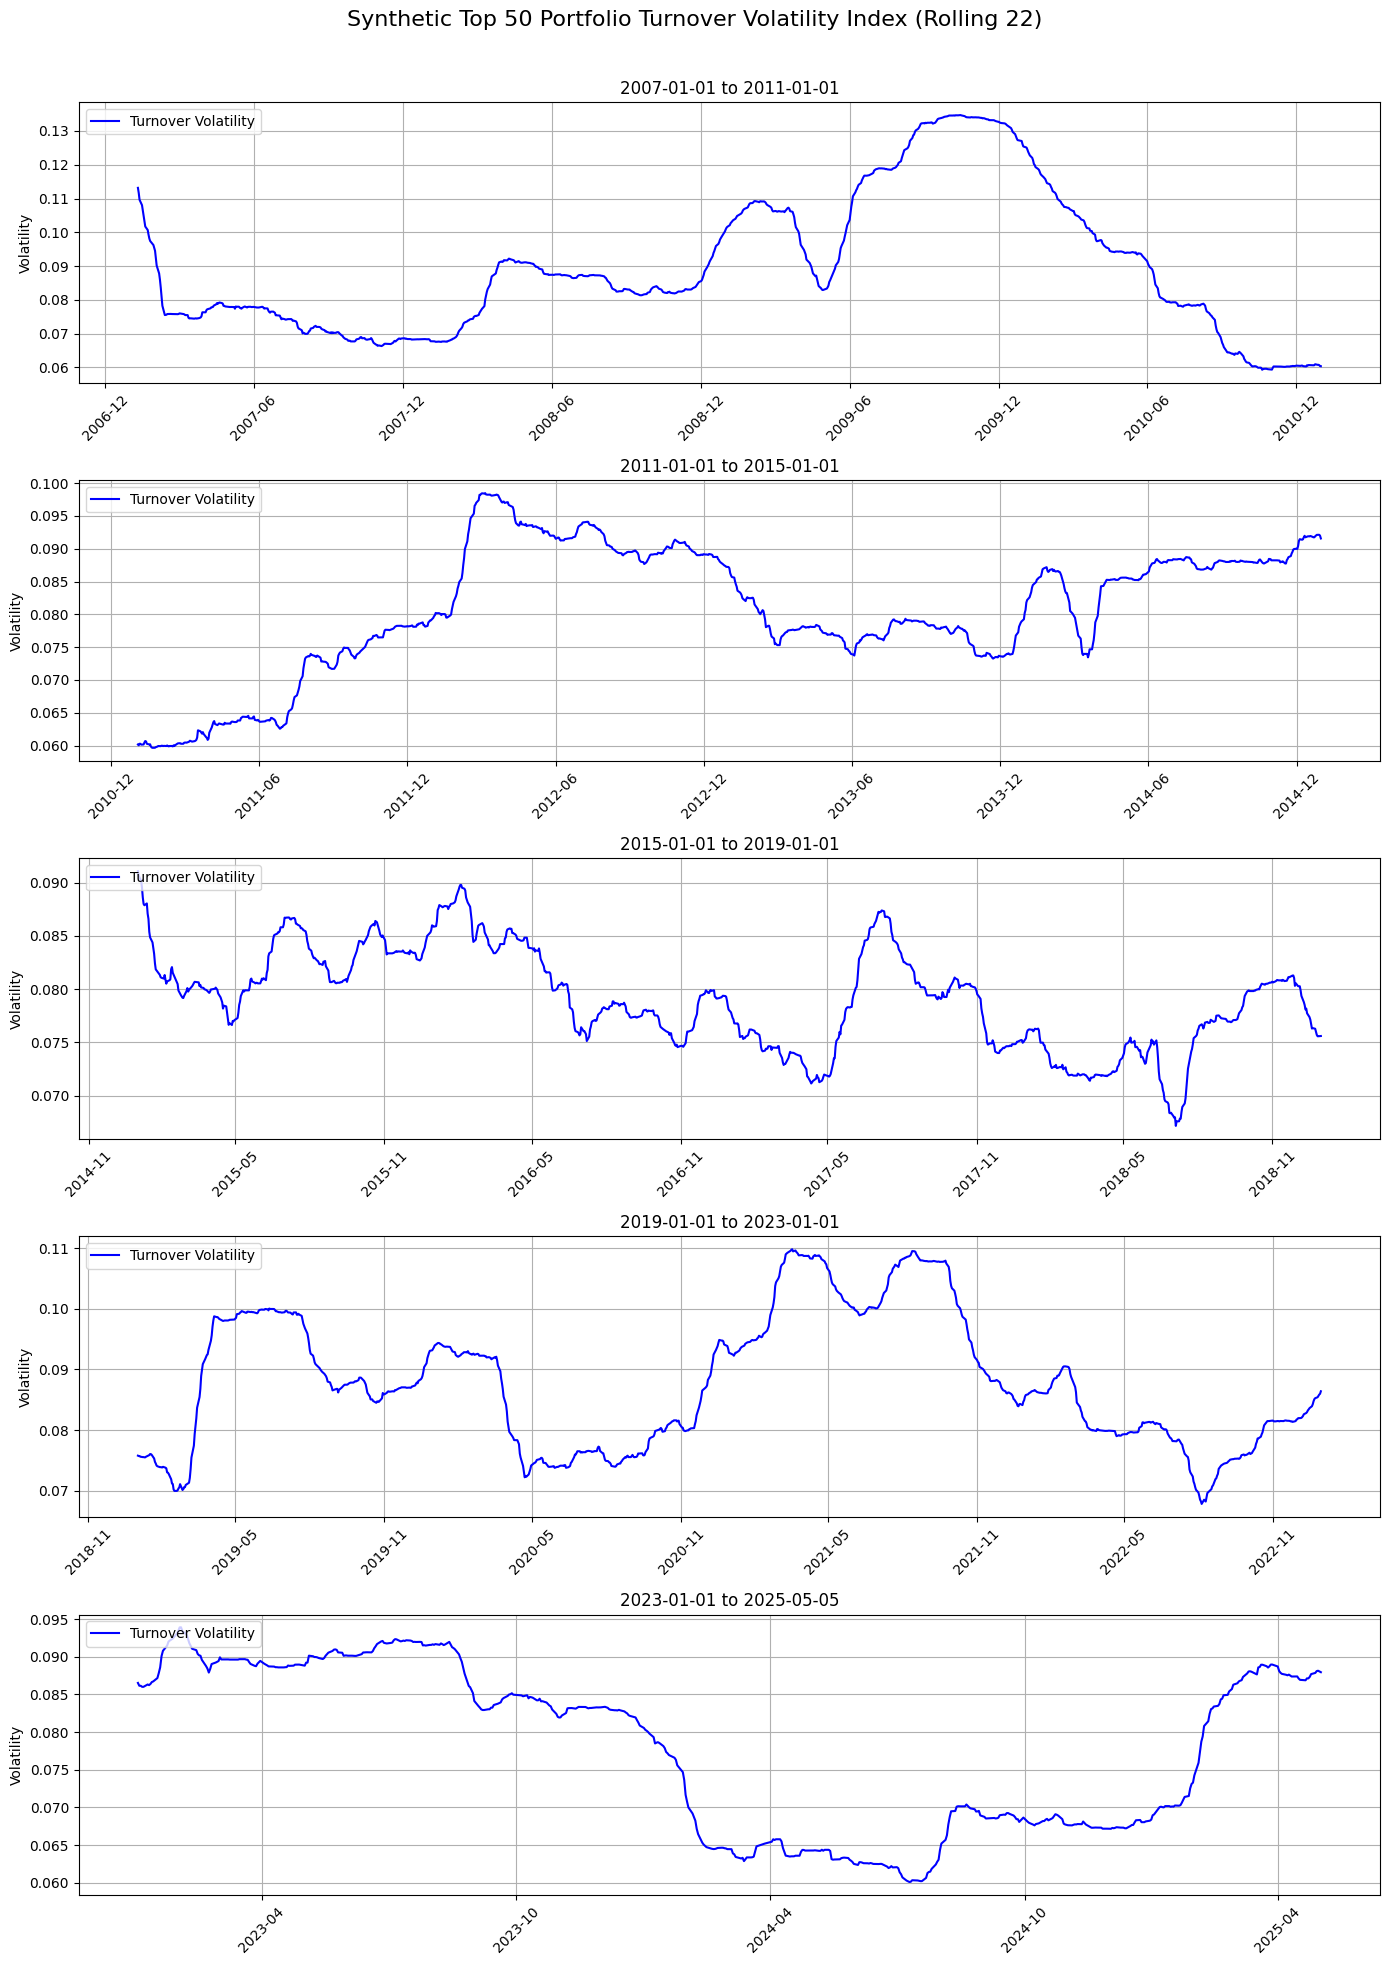

In [21]:
# Calculate rolling volatility of turnover
window = 252
churn_df['Turnover_Volatility'] = churn_df['Turnover_Rate'].rolling(window=window).std()
churn_df['Regime'] = pd.qcut(churn_df['Turnover_Volatility'], 3, labels=['Stable', 'Normal', 'Volatile'])
churn_df['Date'] = pd.to_datetime(churn_df['Date'])

import matplotlib.dates as mdates

# Define 4-year chunks
start_date = churn_df['Date'].min()
end_date = churn_df['Date'].max()
date_ranges = pd.date_range(start=start_date, end=end_date, freq='4YS')
if end_date not in date_ranges:
    date_ranges = date_ranges.append(pd.DatetimeIndex([end_date]))

n_chunks = len(date_ranges) - 1

# Create figure and axes
fig, axs = plt.subplots(n_chunks, 1, figsize=(14, 4 * n_chunks), sharex=False)

# Ensure axs is iterable
if n_chunks == 1:
    axs = [axs]

# Plot each chunk in its subplot
for i in range(n_chunks):
    chunk_start = date_ranges[i]
    chunk_end = date_ranges[i + 1]
    chunk_df = churn_df[(churn_df['Date'] >= chunk_start) & (churn_df['Date'] < chunk_end)]
    
    ax = axs[i]
    ax.plot(chunk_df['Date'], chunk_df['Turnover_Volatility'], color='blue', label='Turnover Volatility')
    ax.set_ylabel('Volatility')
    ax.set_title(f'{chunk_start.date()} to {chunk_end.date()}')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Main title and layout
fig.suptitle('Synthetic Top 50 Portfolio Turnover Volatility Index (Rolling 22)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

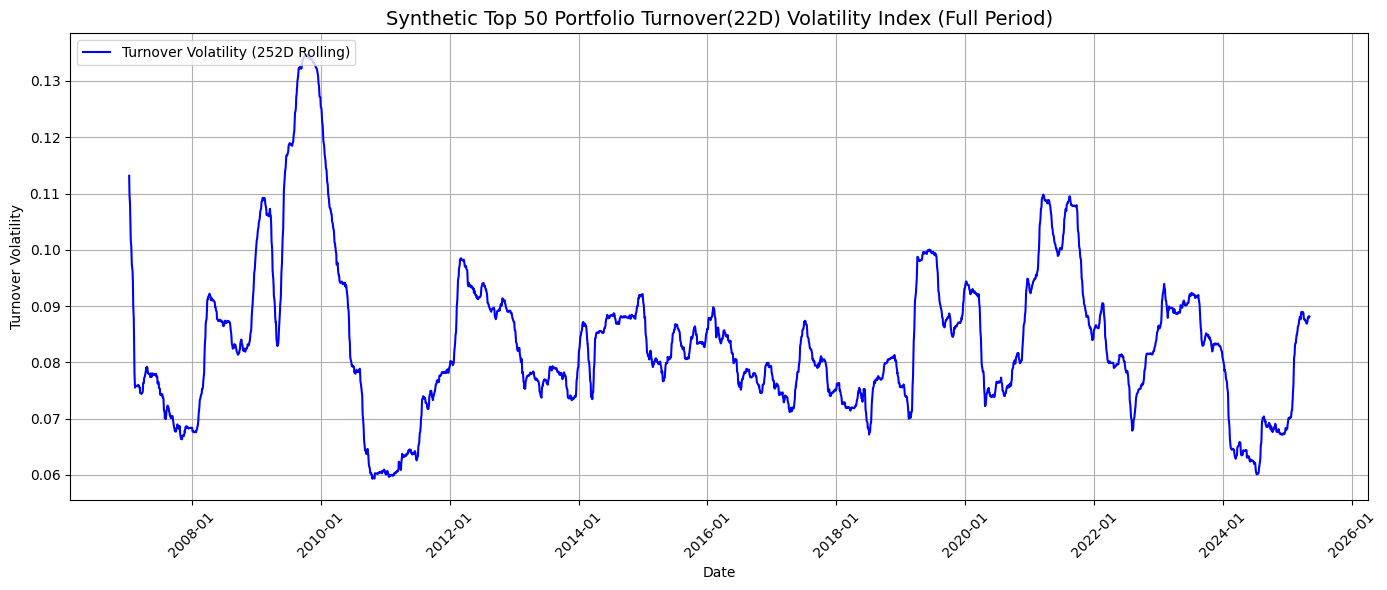

In [23]:
# Plot single chart
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(churn_df['Date'], churn_df['Turnover_Volatility'], color='blue', label='Turnover Volatility (252D Rolling)')
ax.set_ylabel('Turnover Volatility')
ax.set_xlabel('Date')
ax.set_title('Synthetic Top 50 Portfolio Turnover(22D) Volatility Index (Full Period)', fontsize=14)

# X-axis formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
ax.grid(True)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [24]:
df

,Date,Symbol
238371,2025-05-05,ICICIBANK
238387,2025-05-05,HDFCBANK
238353,2025-05-05,BPCL
238360,2025-05-05,SBILIFE
238378,2025-05-05,KOTAKBANK
238352,2025-05-05,HAL
238376,2025-05-05,HDFCLIFE
238351,2025-05-05,UNITDSPR
238390,2025-05-05,AXISBANK
238350,2025-05-05,RADICO


In [26]:
x

,Date,Symbol,Quality,AM,Growth,Dividend,Vol,Value,Theme,LTM,...,MVGQT,VDMT,DMVVol,AM_Growth_Theme,Growth_Vol_AM_Quality,AM_Growth_Quality_Dividend,Style,Total,Rank,EMA
41,2006-01-03,RELIANCE,NaN,0.789668,NaN,NaN,0.987805,NaN,0.255020,0.355460,...,NaN,NaN,NaN,0.522344,NaN,0.789668,0.397643,0.244980,160.0,0.397643
22,2006-01-03,TATAMOTORS,NaN,0.760040,NaN,NaN,0.809756,NaN,0.474900,NaN,...,NaN,NaN,NaN,0.617470,NaN,0.760040,0.427560,0.256627,122.0,0.427560
8,2006-01-03,NATIONALUM,NaN,0.775934,NaN,NaN,0.790244,NaN,0.910643,NaN,...,NaN,NaN,NaN,0.843288,NaN,0.775934,0.535240,0.331727,29.0,0.535240
36,2006-01-03,SIEMENS,NaN,0.912327,NaN,NaN,0.753659,NaN,0.847390,NaN,...,NaN,NaN,NaN,0.879858,NaN,0.912327,0.524903,0.248193,39.0,0.524903
7,2006-01-03,STER,NaN,0.917749,NaN,NaN,0.595122,NaN,0.910643,NaN,...,NaN,NaN,NaN,0.914196,NaN,0.917749,0.577784,0.331727,11.0,0.577784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238372,2025-05-05,CUB,0.605918,0.783168,0.467939,0.665948,0.741525,0.520223,0.706000,0.309025,...,0.655566,0.664976,0.677716,0.652369,0.585736,0.630743,0.700845,0.648002,23.0,0.769173
238383,2025-05-05,RBLBANK,0.413173,0.859910,0.413644,0.627155,0.362288,0.516196,0.706000,0.276600,...,0.650566,0.669620,0.591387,0.659851,0.422087,0.578470,0.701532,0.610377,58.0,0.693549
238392,2025-05-05,HOMEFIRST,0.468245,0.908372,0.695318,0.323276,0.330508,0.477936,0.915000,NaN,...,0.769824,0.656477,0.510023,0.839563,0.527000,0.598803,0.760831,0.586626,27.0,0.760831
238357,2025-05-05,AVANTIFEED,0.379992,0.952386,0.876365,0.642241,0.127119,0.730393,0.477000,0.453835,...,0.707829,0.676736,0.613035,0.768584,0.516100,0.712746,0.763974,0.702976,26.0,0.763974


In [13]:
import glob
import os

# Define the folder path containing the CSV files
folder_path = 'factor_nav_7_5_2025'

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Create an empty DataFrame to store the merged result
merged_df = None

# Process each CSV file
for file in csv_files:
    # Extract the factor/strategy name from the filename
    file_name = os.path.splitext(os.path.basename(file))[0]
    
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Drop 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Convert 'Date' column to datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Get the name of the factor/strategy column (the column that's not 'Date')
    factor_col = [col for col in df.columns if col != 'Date'][0]
    
    # Create a simple DataFrame with just Date and the factor column
    simple_df = df[['Date', factor_col]]
    
    # If this is the first file, initialize the merged DataFrame
    if merged_df is None:
        merged_df = simple_df
    else:
        # Merge with the existing DataFrame
        merged_df = pd.merge(merged_df, simple_df, on='Date', how='outer')

merged_df

,Date,ThemeUltraShortAM,ThemeShortAM,ShiftedAM,ThemeDownVol,ThemeLowBeta,ValuePrice,ThemeAvgVol,Dividend,Mcap,...,LongSectorAM,SectorHighBeta,ThemeLTMA,ThemeAM,GICS,ThemeGrowth,ThemeLongAM,ThemeValueABS,UltraShortSectorAM,ValueABS
0,2006-03-31,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2006-04-03,102.769931,102.481586,102.369889,102.185933,101.774494,102.727455,102.137622,102.640474,102.213732,...,101.840916,103.078483,101.980015,102.059241,102.062774,102.640474,101.998642,102.640474,102.880312,102.640474
2,2006-04-04,102.814496,103.094063,103.433402,103.600218,102.205667,104.113153,102.968706,102.978602,103.197186,...,102.908265,103.458835,103.313113,103.034117,102.343443,102.978602,103.406490,102.978602,103.003351,102.978602
3,2006-04-05,103.839226,104.726520,104.996923,104.508363,103.555643,105.789245,104.116477,104.375147,104.522559,...,104.000731,104.463699,104.286970,104.402783,104.054556,104.375147,104.699965,104.375147,104.683300,104.375147
4,2006-04-07,102.934062,104.318834,104.305059,103.707067,102.903976,103.905525,103.047363,103.141888,102.902834,...,103.774767,103.434155,103.774803,103.991615,103.725306,103.141888,104.171625,103.141888,104.290743,103.141888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4705,2025-04-29,1735.898506,2440.899853,2197.928934,1613.687927,2031.502526,196.189792,1292.047196,1436.802990,417.338622,...,2091.766365,411.527017,1839.873235,3278.472004,241.675260,1896.770243,1755.914746,1016.174616,1607.125456,1906.574643
4706,2025-04-30,1710.461581,2398.060601,2163.546318,1606.150209,2018.246057,195.183728,1288.115254,1425.701602,414.914858,...,2081.157430,406.478281,1816.682853,3230.055998,239.884774,1866.947496,1730.874697,1002.923059,1592.707617,1886.096706
4707,2025-05-02,1709.679803,2402.810044,2168.163098,1604.751324,2006.408974,194.656516,1282.607573,1426.016597,414.576522,...,2075.538618,404.150371,1811.039034,3230.408918,237.909882,1858.238068,1723.563694,1005.639053,1587.152257,1882.730995
4708,2025-05-05,1731.144102,2444.157503,2201.337153,1623.330693,2023.844189,197.615090,1297.559951,1445.299363,419.137700,...,2097.728654,410.716313,1830.775638,3267.549713,241.487655,1883.582141,1740.952170,1018.261292,1609.123932,1917.357504


In [104]:
merged_df = merged_df[['Date','AM', 'AntiTrendMR','TrendMR','SectorAM','LowVol','GrowthConsol','QualityAnnualConsol','ValueABS']]

In [108]:
vol = merged_df[['Date','TrendMR']]
alpha = merged_df[['Date','QualityAnnualConsol']]

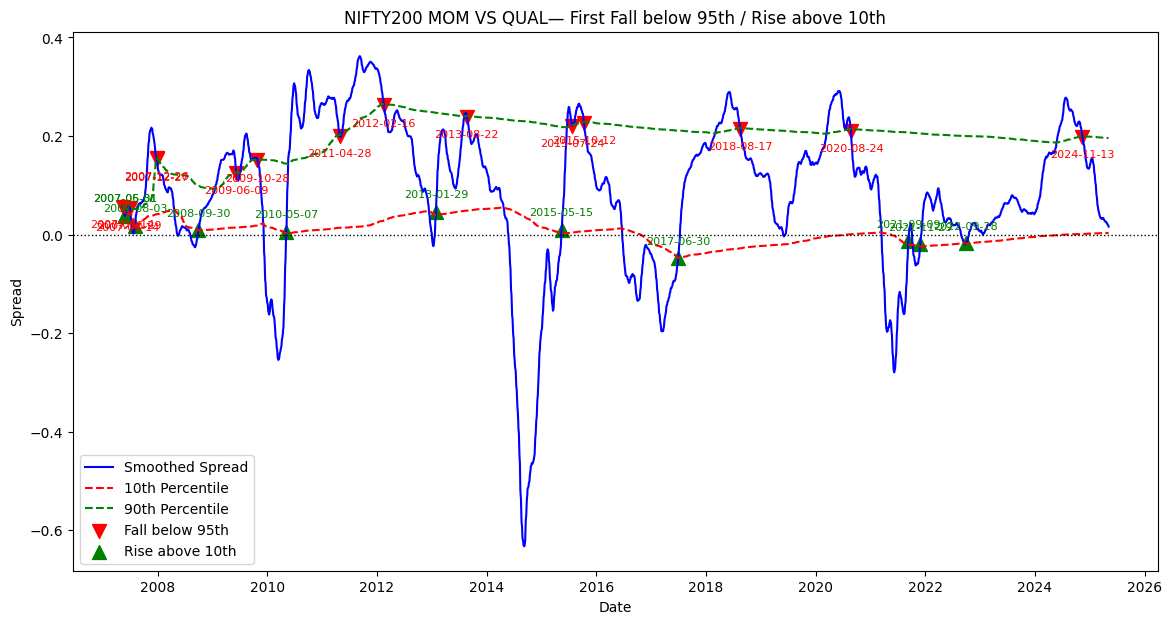

In [109]:
# Preprocess
alpha['Date'] = pd.to_datetime(alpha['Date'])
vol['Date'] = pd.to_datetime(vol['Date'])

alpha.set_index('Date', inplace=True)
vol.set_index('Date', inplace=True)

# Align NAVs
combined = pd.DataFrame({
    'Alpha_NAV': alpha['QualityAnnualConsol'],
    'Vol_NAV': vol['TrendMR']
}).dropna()

# Rolling returns
combined['Alpha_1Y_Return'] = combined['Alpha_NAV'].pct_change(252)
combined['Vol_1Y_Return'] = combined['Vol_NAV'].pct_change(252)

# Spread and Smoothing
combined['Spread'] = combined['Alpha_1Y_Return'] - combined['Vol_1Y_Return']
combined['Smoothed_Spread'] = combined['Spread'].rolling(22).mean()

# Expanding percentil'es
combined['P10'] = combined['Smoothed_Spread'].expanding().quantile(0.20)
combined['P90'] = combined['Smoothed_Spread'].expanding().quantile(0.75)

# Drop NaNs
combined = combined.dropna(subset=['Smoothed_Spread', 'P10', 'P90'])

# Create two boolean series
# 1. Fall below P90
fall_below_95 = (combined['Smoothed_Spread'] < combined['P90']) & (combined['Smoothed_Spread'].shift(1) >= combined['P90'])

# 2. Rise above P10
rise_above_10 = (combined['Smoothed_Spread'] > combined['P10']) & (combined['Smoothed_Spread'].shift(1) <= combined['P10'])

# Get dates
fall_below_95_dates = combined.index[fall_below_95]
rise_above_10_dates = combined.index[rise_above_10]

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(combined.index, combined['Smoothed_Spread'], label='Smoothed Spread', color='blue')
ax.plot(combined.index, combined['P10'], label='10th Percentile', linestyle='dashed', color='red')
ax.plot(combined.index, combined['P90'], label='90th Percentile', linestyle='dashed', color='green')
ax.axhline(0, color='black', linewidth=1, linestyle='dotted')

# Mark fall below 95
ax.scatter(fall_below_95_dates, combined.loc[fall_below_95_dates, 'Smoothed_Spread'], color='red', marker='v', s=100, label='Fall below 95th')

# Mark rise above 10
ax.scatter(rise_above_10_dates, combined.loc[rise_above_10_dates, 'Smoothed_Spread'], color='green', marker='^', s=100, label='Rise above 10th')

# Annotate
for idx in fall_below_95_dates:
    ax.annotate(idx.strftime('%Y-%m-%d'), xy=(idx, combined.loc[idx, 'Smoothed_Spread']),
                xytext=(0, -15), textcoords='offset points', ha='center', fontsize=8, color='red')

for idx in rise_above_10_dates:
    ax.annotate(idx.strftime('%Y-%m-%d'), xy=(idx, combined.loc[idx, 'Smoothed_Spread']),
                xytext=(0, 10), textcoords='offset points', ha='center', fontsize=8, color='green')

# Final touches
ax.legend()
# ax.set_title('MIDCAP 150 Alpha vs Volatility Portfolio — First Fall below 95th / Rise above 10th')
ax.set_title('NIFTY200 MOM VS QUAL— First Fall below 95th / Rise above 10th')

ax.set_xlabel('Date')
ax.set_ylabel('Spread')

plt.show()

In [110]:
# Create DataFrame with signal type and values
signals_df = pd.DataFrame({
    'Date': list(fall_below_95_dates) + list(rise_above_10_dates),
    'Smoothed_Spread': list(combined.loc[fall_below_95_dates, 'Smoothed_Spread']) +
                       list(combined.loc[rise_above_10_dates, 'Smoothed_Spread']),
    'Signal': ['Fall below 95th'] * len(fall_below_95_dates) + ['Rise above 10th'] * len(rise_above_10_dates)
})

# Sort by date
signals_df.sort_values('Date', inplace=True)

# Reset index for a clean DataFrame
signals_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(signals_df)

         Date  Smoothed_Spread           Signal
0  2007-05-14         0.055801  Fall below 95th
1  2007-05-31         0.038310  Rise above 10th
2  2007-06-01         0.039628  Rise above 10th
3  2007-06-14         0.051212  Fall below 95th
4  2007-06-29         0.054462  Fall below 95th
5  2007-08-03         0.017822  Rise above 10th
6  2007-12-26         0.154700  Fall below 95th
7  2007-12-27         0.152454  Fall below 95th
8  2008-09-30         0.009221  Rise above 10th
9  2009-06-09         0.125082  Fall below 95th
10 2009-10-28         0.150387  Fall below 95th
11 2010-05-07         0.005893  Rise above 10th
12 2011-04-28         0.200823  Fall below 95th
13 2012-02-16         0.262531  Fall below 95th
14 2013-01-29         0.046297  Rise above 10th
15 2013-08-22         0.239417  Fall below 95th
16 2015-05-15         0.009785  Rise above 10th
17 2015-07-24         0.220882  Fall below 95th
18 2015-10-12         0.226955  Fall below 95th
19 2017-06-30        -0.047260  Rise abo

<Axes: xlabel='Date'>

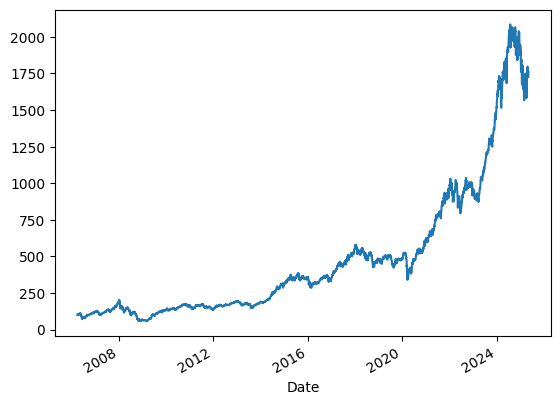

In [80]:
vol['AntiTrendMR'].plot()